In [1]:
# Import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer 

In [2]:
file = 'standardized_paysim.csv'
path = '../Data/'

paysim = pd.read_csv(path+file)

In [3]:
y =  paysim['isFraud']
X =  paysim.loc[:, paysim.columns != 'isFraud']
seed = 1
# 

In [4]:
from sklearn.model_selection import train_test_split
t_size=0.30
# 
start = timer()
# Orig Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size, random_state=seed, stratify=y)

end = timer()
print(f'{(end - start)} seconds elapsed.')

3.9537332769999978 seconds elapsed.


# Import & Seed

In [10]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
# 
seed = 1
# 
sample_weights = compute_class_weight('balanced', classes=np.unique(y_train.values), y=y_train.values)
it = [1,0]

# 
weights = dict(zip(it, sample_weights))
print(weights)

{1: 0.5006462331542675, 0: 387.35727952687427}


# Random Forest

2min 16s ± 3.05 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.99      0.80      0.89      2464

    accuracy                           1.00   1908786
   macro avg       0.99      0.90      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786

[[1906298      24]
 [    487    1977]]




                    % Importance
amount                  0.257175
diffBalanceDest         0.215839
oldbalanceOrig          0.164262
step                    0.112128
oldbalanceDest          0.109031
diffBalanceOrig         0.065381
transType_TRANSFER      0.044711
transType_CASH_OUT      0.025500
transType_PAYMENT       0.003391
nameDest_M              0.001595
transType_DEBIT         0.000987
18.45335126065 Min elapsed.


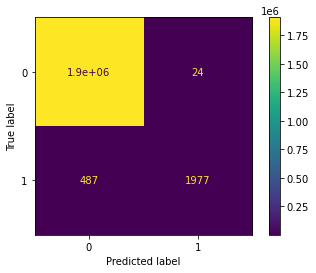

In [6]:
from sklearn.ensemble import RandomForestClassifier

start = timer()
#
params_fixed = {
    'n_jobs' : (-1),
    'random_state' : seed,
}

rfc = RandomForestClassifier(**params_fixed)

%timeit rfc.fit(X_train, y_train)
# 
y_predRFC = rfc.predict(X_test)
print('\n')
print(classification_report(y_test, y_predRFC))
print(confusion_matrix(y_test, y_predRFC))
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=(confusion_matrix(y_test, y_predRFC)), display_labels=rfc.classes_)
disp.plot()
print('\n')
df0 = pd.DataFrame(rfc.feature_importances_, index=X.columns, columns=["% Importance"])
print(df0.sort_values("% Importance", axis=0, ascending=False))
end = timer()
print(f'{(end - start)/60} Min elapsed.')

2min 24s ± 2.75 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.99      0.80      0.88      2464

    accuracy                           1.00   1908786
   macro avg       0.99      0.90      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786

[[1906297      25]
 [    499    1965]]




                    % Importance
amount                  0.261769
diffBalanceDest         0.239763
step                    0.179648
oldbalanceOrig          0.175835
oldbalanceDest          0.070037
diffBalanceOrig         0.022782
transType_CASH_OUT      0.021125
transType_TRANSFER      0.017961
transType_PAYMENT       0.010296
nameDest_M              0.000702
transType_DEBIT         0.000081
19.3352641538 Min elapsed.


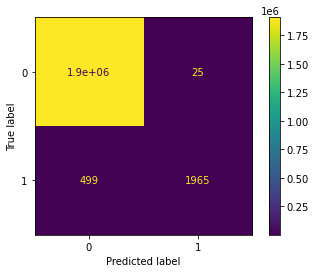

In [7]:
from sklearn.ensemble import RandomForestClassifier

start = timer()
# 
params_fixed = {
    'class_weight': weights,
    'n_jobs' : (-1),
    'random_state' : seed,
}

rfc_w = RandomForestClassifier(**params_fixed)

%timeit rfc_w.fit(X_train, y_train)
# 
y_predRFCw = rfc_w.predict(X_test)
print('\n')
print(classification_report(y_test, y_predRFCw))
print(confusion_matrix(y_test, y_predRFCw))
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=(confusion_matrix(y_test, y_predRFCw)), display_labels=rfc_w.classes_)
disp.plot()
print('\n')
df0 = pd.DataFrame(rfc_w.feature_importances_, index=X.columns, columns=["% Importance"])
print(df0.sort_values("% Importance", axis=0, ascending=False))
end = timer()
print(f'{(end - start)/60} Min elapsed.')


# Random forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

start = timer()
# 
params_grid = {
'n_estimators': range(100, 500, 100),
# 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
}
# 
params_fixed = {
    'class_weight': weights,
    'n_jobs' : (-1),
    'random_state' : seed,
}

# 
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3, 0.5]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate' : learning_rate,
               'bootstrap': bootstrap}

# Model
rfc_w = RandomForestClassifier(**params_fixed)

# Model Random
rfc_random = RandomizedSearchCV(estimator = rfc_w, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, 
                   random_state=seed, n_jobs = -1)

# 
start = timer()
# 
#Train the model using the training sets
%timeit rfc_random.fit(X_train, y_train)
# 
s_p = timer()
# 
y_predRFCw = rfc_random.predict(X_test)
e_p = timer()
print(f'{(e_p - s_p)} Sec elapsed for prediction.')
# 

y_predRFCw = rfc_w.predict(X_test)
print('\n')
print(classification_report(y_test, y_predRFCw))
print(confusion_matrix(y_test, y_predRFCw))
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=(confusion_matrix(y_test, y_predRFCw)), display_labels=rfc_w.classes_)
disp.plot()
print('\n')
df0 = pd.DataFrame(rfc_w.feature_importances_, index=X.columns, columns=["% Importance"])
print(df0.sort_values("% Importance", axis=0, ascending=False))
print('\n')
print(rfc_w.best_estimator_)
end = timer()
print(f'{(end - start)/60} Min elapsed.')
print('\n')

In [ ]:
start = timer()
# 
#Train the model using the training sets
%timeit clf_random.fit(X_train_rus, y_train_rus)
# 
s_p = timer()
y_pred=clf_random.predict(X_test_rus)
e_p = timer()
print(f'{(e_p - s_p)} Sec elapsed.')
# 
print('\n')
print(classification_report(y_test_rus, y_pred))
print(confusion_matrix(y_test_rus, y_pred))
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=(confusion_matrix(y_test_rus, y_pred)), 
                              display_labels=clf_random.classes_)
disp.plot()
print('\n')
end = timer()
print(f'{(end - start)/60} Min elapsed.')

# LGBM Classifier

In [ ]:
from lightgbm import LGBMClassifier

start = timer()
# Define model
lgbm_cl = LGBMClassifier(random_state=seed, is_unbalance = True, n_jobs=-1)

#Train the model using the training sets
%timeit lgbm_cl.fit(X_train,y_train)
# 
y_predLGBM = lgbm_cl.predict(X_test)
print('\n')
print(classification_report(y_test, y_predLGBM))
print(confusion_matrix(y_test, y_predLGBM))
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=(confusion_matrix(y_test, y_predLGBM)), 
                              display_labels=lgbm_cl.classes_)
disp.plot()
print('\n')
end = timer()
print(f'{(end - start)/60} Min elapsed.')

In [ ]:
from lightgbm import LGBMClassifier

start = timer()
# Define model
lgbm_cl = LGBMClassifier(random_state=seed, n_jobs=-1)

#Train the model using the training sets
%timeit lgbm_cl.fit(X_train,y_train)
# 
y_predLGBM = lgbm_cl.predict(X_test)
print('\n')
print(classification_report(y_test, y_predLGBM))
print(confusion_matrix(y_test, y_predLGBM))
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=(confusion_matrix(y_test, y_predLGBM)), 
                              display_labels=lgbm_cl.classes_)
disp.plot()
print('\n')
end = timer()
print(f'{(end - start)/60} Min elapsed.')

# XGB Classifier

In [ ]:
from xgboost import XGBClassifier
# 
start = timer()
# 
x = y_test.value_counts()

# Define model
xgb_cl = XGBClassifier(objective ='binary:logistic', eval_metric = "logloss", n_jobs=-1, random_state=seed, 
                       scale_pos_weight=(x[0]/x[1]),use_label_encoder=False)

#Train the model using the training sets
xgb_cl.fit(X_train,y_train)
# 
y_predXGB=xgb_cl.predict(X_test)
print('\n')
print(classification_report(y_test, y_predXGB))
print(confusion_matrix(y_test, y_predXGB))
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=(confusion_matrix(y_test, y_predXGB)), 
                              display_labels=xgb_cl.classes_)
disp.plot()
print('\n')
end = timer()
print(f'{(end - start)/60} Min elapsed.')